## Introduction:
The goal of this project is to establish a robust intelligent system to aid in value investing efforts using stock market data. The system will help make investment decisions and based on intrinsic value of companies. It will not, however, trade on the basis of daily market volatility. This project is a part 5 of a series of 7 companies. At the end of the project we will be able to:


1.   Predict stock price valuations on a daily, weekly and monthly basis
2.   Recommend to buy, sell or hold based on certain decision parameters
3.   Maximize capital returns, minimise loses, and minise hold periods

## Loading Libraries And Data For Argentina Pampa Energia SA

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

In [ ]:
df = pd.read_excel('/content/2020Q1Q2Q3Q4-2021Q1.xlsx', sheet_name='Argentina - Pampa Energia SA (P')

In [ ]:
df.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,2021-03-31 00:00:00,85.15,86.5,88.1,85.15,564.30K,-0.0110
1,2021-03-30 00:00:00,86.1,85.15,86.75,84.6,141.40K,0.0129
2,2021-03-29 00:00:00,85,80,86,79,371.22K,0.0385
3,2021-03-26 00:00:00,81.85,84,84.6,80.7,462.55K,-0.0209
4,2021-03-25 00:00:00,83.6,85.2,87.3,82.1,389.78K,-0.0313


## Data Wrangling

In [ ]:
df.shape

(301, 7)

In [ ]:
df.tail()

,Date,Price,Open,High,Low,Vol.,Change %
296,2020-01-07 00:00:00,47.6,48.35,49,46.9,901.95K,-0.0186
297,2020-01-06 00:00:00,48.5,48.4,48.7,47,719.24K,-0.0061
298,2020-01-03 00:00:00,48.8,48.25,49.45,46.5,595.36K,0.0114
299,2020-01-02 00:00:00,48.25,49.35,50.2,47.55,878.50K,-0.0292
300,Highest: 90.000,Lowest: 32.000,Difference: 58.000,Average: 61.244,Change %: 71.328,NaN,NaN


In [ ]:
df = df[:-1]

In [ ]:
df.dtypes

Date         object
Price        object
Open         object
High         object
Low          object
Vol.         object
Change %    float64
dtype: object

In [ ]:
df.isna().any()

Date        False
Price       False
Open        False
High        False
Low         False
Vol.        False
Change %    False
dtype: bool

In [ ]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

In [ ]:
def convert_volume(x):
    if x.endswith('K'):
        return float(x[:-1]) * 1000
    elif x.endswith('M'):
        return float(x[:-1]) * 1000000
    else:
        return float(x)

In [ ]:
df['Vol.'] = df['Vol.'].apply(convert_volume)

In [ ]:
for i in df.columns:
  if df[i].dtype == 'object':
    df[i] = df[i].astype(float)

In [ ]:
df['Price'].describe()

count    300.000000
mean      61.244000
std       16.163933
min       33.000000
25%       46.850000
50%       57.750000
75%       78.500000
max       88.900000
Name: Price, dtype: float64

## Exploratory Data Analysis

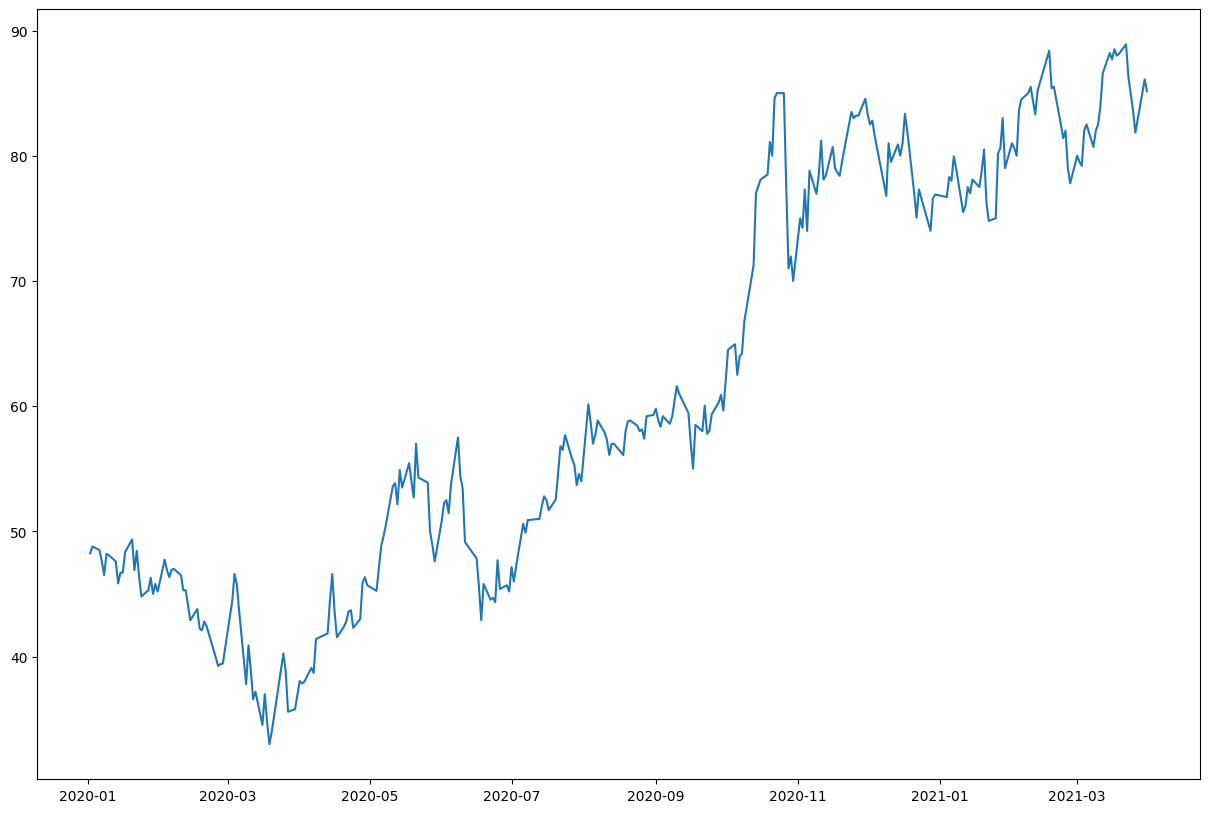

In [ ]:
plt.figure(figsize=(15, 10))
plt.plot(df['Price'])
plt.show()

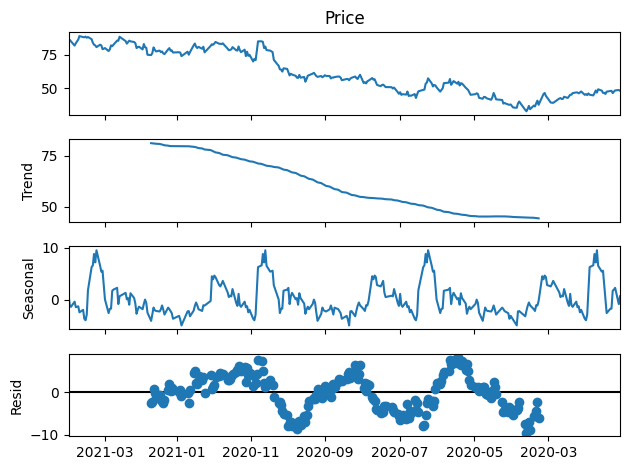

In [ ]:
decomp = seasonal_decompose(df['Price'], model='additive', period=90)
decomp.plot()
plt.show()

In [ ]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
result = adfuller(df['Price'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values: ')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.449051
p-value: 0.558548
Critical Values: 
	1%: -3.452
	5%: -2.871
	10%: -2.572


In [ ]:
def stationarity_check(value):
  if value < 0.05:
    print(f'Data is Stationary')
  else:
    print(f'Data is Non-Stationary')
stationarity_check(result[1])

Data is Non-Stationary


In [ ]:
df['price_diff'] = df['Price'].diff()
df.dropna(inplace=True)

In [ ]:
df['rolling_mean_diff'] = df['price_diff'].rolling(window=5).mean()
df.dropna(inplace=True)

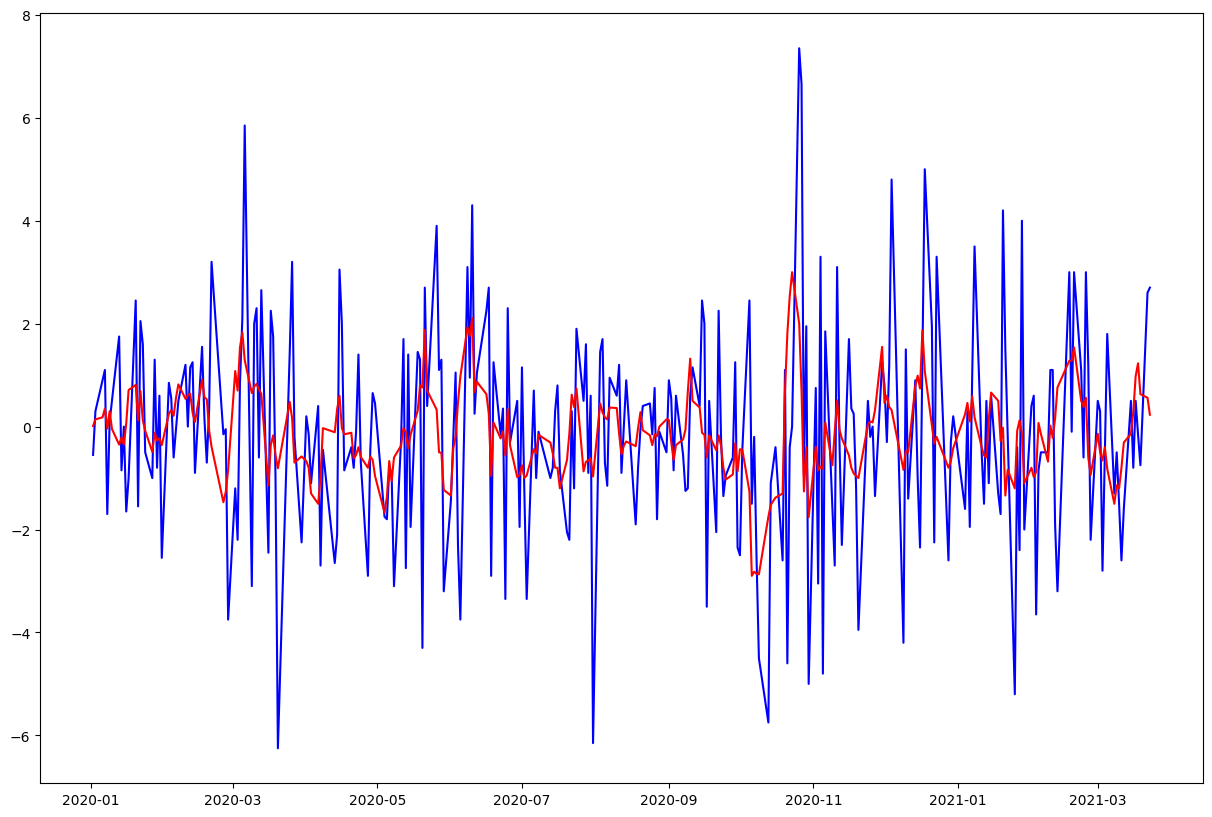

In [ ]:
plt.figure(figsize=(15, 10))
plt.plot(df['price_diff'], color='blue')
plt.plot(df['rolling_mean_diff'], color='red')
plt.show()

In [ ]:
result = adfuller(df['rolling_mean_diff'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values: ' )
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.872443
p-value: 0.002247
Critical Values: 
	1%: -3.454
	5%: -2.872
	10%: -2.572


## Modeling And Preprocessing

In [ ]:
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA

In [ ]:
df_train = df['2020-01-01':'2021-01-01']
df_test = df['2021-01-01':]


In [ ]:
def evaluate_arima_model(data, arima_order):
  train, test = df_train['rolling_mean_diff'].values, df_test['rolling_mean_diff'].values
  past = [x for x in train]
  predictions = list()
  for t in range(len(test)):
    model = ARIMA(past, order=arima_order)
    model_fit = model.fit()
    future = model_fit.forecast()[0]
    predictions.append(future)
    past.append(test[t])
  error = mean_squared_error(test, predictions)
  return error

In [ ]:
def evaluate_models(data, p_values, d_values, q_values):
  best_score, best_cfg = float("inf"), None
  for p in p_values:
    for d in d_values:
      for q in q_values:
        order = (p, q, d)
        try:
          mse = evaluate_arima_model(data, order)
          if mse < best_score:
            best_score, best_cfg = mse, order
          print('ARIMA%s MSE=%.3f' % (order, mse))
        except:
          continue
  return print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

In [ ]:
p_values = [x for x in range(0, 3)]
d_values = [x for x in range(0, 3)]
q_values = [x for x in range(0, 3)]

In [ ]:
#evaluate_models(df_train['rolling_mean_diff'].values, p_values, d_values, q_values)

In [ ]:
p = 1
d = 1
q = 2
model = ARIMA(df_train['rolling_mean_diff'], order=(p, d, q))
model_fit = model.fit()
forecast = model_fit.forecast(steps=len(df_test))

## Plotting ARIMA Model

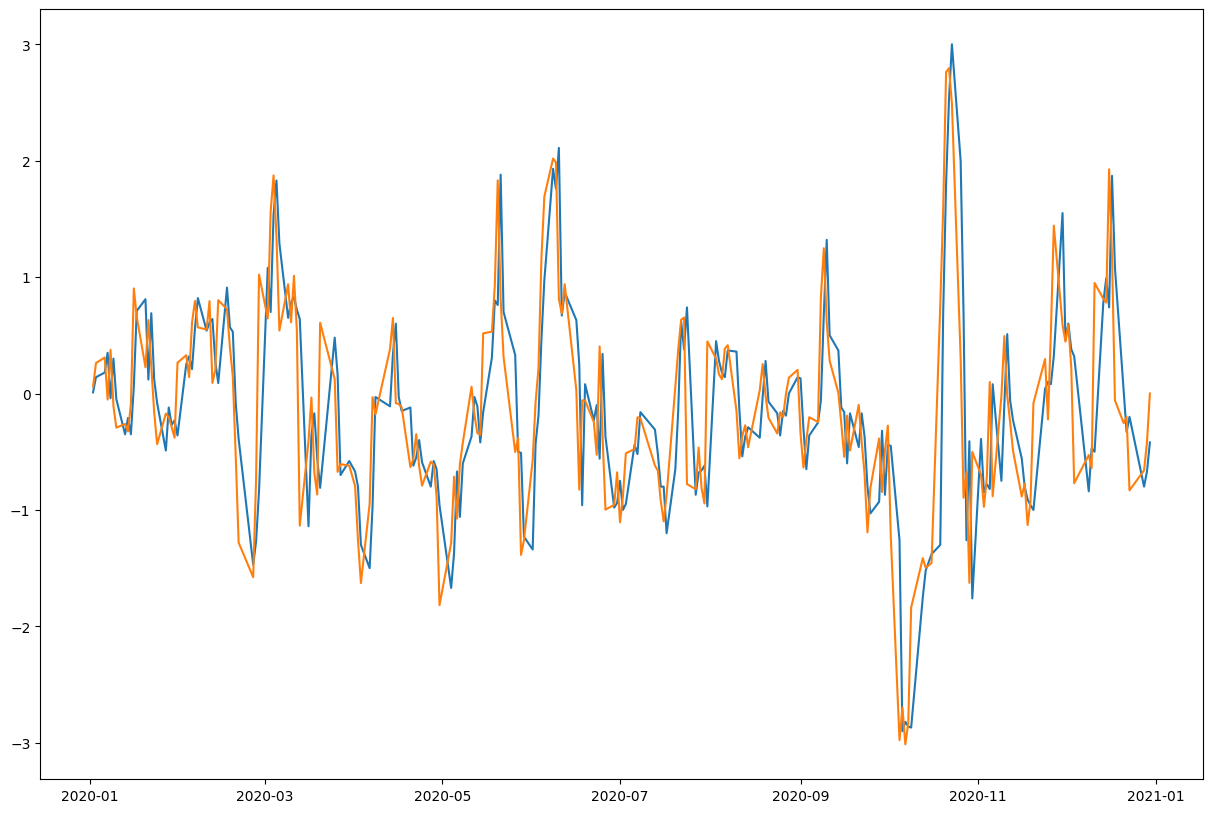

In [ ]:
plt.figure(figsize=(15, 10))
plt.plot(df_train['rolling_mean_diff'])
plt.plot(model_fit.predict())
plt.show()

In [ ]:
future_cast = model_fit.forecast(len(df_test))
future_cast.index = df_test.index
future_cast = pd.DataFrame(future_cast)
future_cast.columns = ['rolling_mean_diff']

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


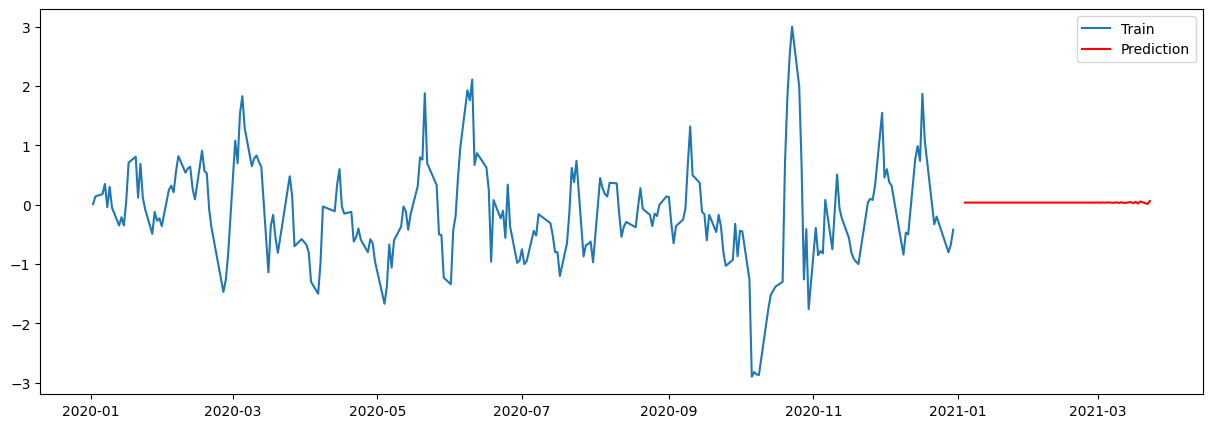

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(df_train['rolling_mean_diff'], label='Train')
plt.plot(future_cast['rolling_mean_diff'], color='red', label='Prediction')
plt.legend()
plt.show()

## Back Testing The Model

In [ ]:
def evaluate_arima_model(data, arima_order, start_train_size):
    history = list(data[:start_train_size])
    predictions = []
    for t in range(start_train_size, len(data)):

        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        future = model_fit.forecast(7)[-1]
        predictions.append(future)
        history.append(data[t])
    mse = mean_squared_error(data[start_train_size:], predictions)
    mpe = mean_absolute_percentage_error(data[start_train_size:], predictions)

    return mse , mpe, predictions

In [ ]:
mse, mpe, predictions = evaluate_arima_model(df['rolling_mean_diff'].sort_index(), (1, 1, 1), len(df_train))

In [ ]:
forecast = pd.DataFrame(predictions)
forecast.columns = ['rolling_mean_diff']
forecast.index = df_test.index[::-1]
forecast.head()

,rolling_mean_diff
Date,
2021-01-04,-0.400269
2021-01-05,0.180043
2021-01-06,0.489175
2021-01-07,0.102735
2021-01-08,0.554754


In [ ]:
f_std = forecast['rolling_mean_diff'].std()

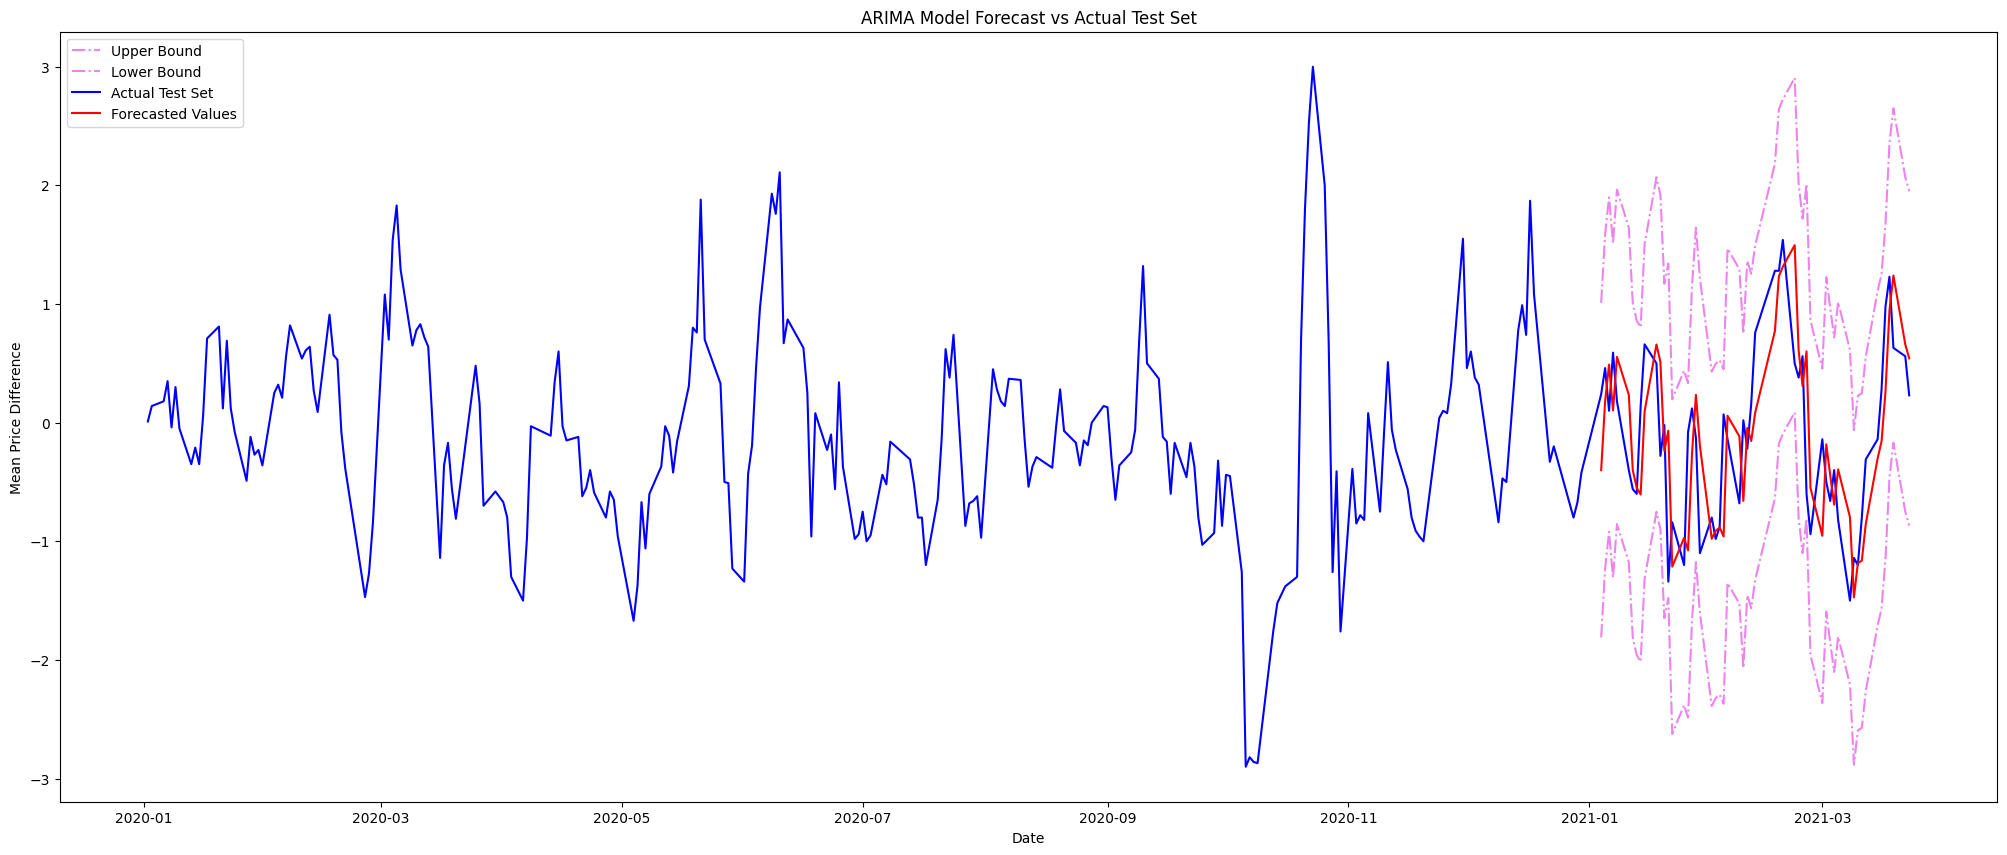

In [ ]:
plt.figure(figsize=(25,10))
plt.plot(forecast['rolling_mean_diff'] + 1.96*f_std, label='Upper Bound', color='violet', linestyle='-.')
plt.plot(forecast['rolling_mean_diff'] - 1.96*f_std, label='Lower Bound', color='violet', linestyle='-.')

plt.plot(df['rolling_mean_diff'], label='Actual Test Set', color='blue')

plt.plot(forecast, label='Forecasted Values', color='red')

plt.title('ARIMA Model Forecast vs Actual Test Set')
plt.xlabel('Date')
plt.ylabel('Mean Price Difference')
plt.legend()
plt.show()

In [ ]:
o_std = df['rolling_mean_diff'].std()

## Decisions: Buy, Sell, Hold

In [ ]:
def buy_sell_hold(forecast, look_ahead, data, threshold=1.96):
  standard_dev = data['rolling_mean_diff'].std()
  decisions = []
  open_prices = []
  dates = []
  buy_sell_flag = 'buy'
  for i in range(len(forecast) - look_ahead):
    if standard_dev is None:
      return "Please provide standard deviation"
    else:
      open_prices.append(data['Open'].iloc[i])
      dates.append(forecast.index[i])
      if (forecast.iloc[i + look_ahead] > forecast.iloc[i] + threshold * standard_dev) & (buy_sell_flag != 'buy'):
        decisions.append('buy')
        buy_sell_flag = 'buy'
      elif (forecast.iloc[i + look_ahead] < forecast.iloc[i] - threshold * standard_dev) & (buy_sell_flag != 'sell'):
        decisions.append('sell')
        buy_sell_flag = 'sell'
      else:
        decisions.append('hold')
  df = pd.DataFrame({'Decision': decisions, 'Open': open_prices}, index=dates)
  return df

In [ ]:
decision_df = buy_sell_hold(forecast['rolling_mean_diff'], look_ahead=7, data=df, threshold=0.1)

In [ ]:
decision_df.head(30)

,Decision,Open
2021-01-04,sell,88.00
2021-01-05,hold,87.00
2021-01-06,hold,87.00
2021-01-07,buy,88.45
2021-01-08,hold,87.00
2021-01-11,sell,87.05
2021-01-12,buy,86.80
2021-01-13,sell,82.00
2021-01-14,hold,82.50
2021-01-15,hold,82.00


## Assessing Profit Based On Decision Parameters

In [ ]:
def decision_score(lst):
  score = 0
  for i in range(len(lst)):
    if lst[i] == 'buy':
      score += 1
    elif lst[i] == 'sell':
      score -= 1
    else:
      score += 0
  return score

In [ ]:
decision_score(decision_df['Decision'])

0